In [27]:
%matplotlib inline

In [282]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
from paths import DATA_PATH
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from torchinfo import summary

from sklearn.preprocessing import MinMaxScaler

In [283]:
df = pd.read_csv(DATA_PATH / 'news_stocks.csv', parse_dates=True)
df = df.reindex(index=df.index[::-1]).reset_index(drop=True)
df

,date,title,text,link,author,label,open,high,low,close,volume
0,2022-05-08,Заявки на транзит российского газа через Украи...,На уровне более 90 миллионов кубометров заявки...,https://www.finam.ru/publications/item/zayavki...,РИА Новости,positive,124.30,126.41,120.90,121.11,580965.0
1,2022-05-08,Юань - хороший инструмент для хеджирования рис...,Ввиду сильной экономики Китая юань менее подве...,https://www.finam.ru/publications/item/yuan-xo...,"Жильников Егор, ""Промсвязьбанк""",positive,124.30,126.41,120.90,121.11,580965.0
2,2022-05-08,"""Сбербанк"" увеличил сумму кредита по ипотеке с...",Сумма кредита по ипотеке с господдержкой увели...,https://www.finam.ru/publications/item/sberban...,Finam.ru,positive,124.30,126.41,120.90,121.11,580965.0
3,2022-05-08,Постпреды ЕС в воскресенье не достигли соглаше...,Венгрия продолжает блокировать предложение Евр...,https://www.finam.ru/publications/item/postpre...,РИА Новости,negative,124.30,126.41,120.90,121.11,580965.0
4,2022-05-08,Реальные доходы россиян в 2022 году могут упас...,По отношению к пиковому 2013 году реальные рас...,https://www.finam.ru/publications/item/realnye...,"Суворов Евгений, банк ""ЦентроКредит""",negative,124.30,126.41,120.90,121.11,580965.0
...,...,...,...,...,...,...,...,...,...,...,...
30609,2023-05-06,Результаты Ford по итогам прошедшего года можн...,Компания явно демонстрирует постепенное урегул...,https://www.finam.ru/publications/item/rezulta...,"Поздняков Дмитрий, Freedom Finance Global",positive,235.83,240.93,233.42,237.06,11352.0
30610,2023-05-06,"Банки США - депозиты сокращаются, кредиты растут",Ребалансировка балансов банков продолжается,https://www.finam.ru/publications/item/banki-s...,Сусин Егор,negative,235.83,240.93,233.42,237.06,11352.0
30611,2023-05-06,"Закрытие дивидендного реестра по ""Сбербанку"" с...",Последний день с рекордными дивидендами акции ...,https://www.finam.ru/publications/item/zakryti...,"Кожухова Елена, ИК ""Велес Капитал""",positive,235.83,240.93,233.42,237.06,11352.0
30612,2023-05-06,Встреча по зерновой сделке на уровне заместите...,"Встреча пройдет с участием России, Украины, Ту...",https://www.finam.ru/publications/item/vstrech...,Finam.ru,positive,235.83,240.93,233.42,237.06,11352.0


# using sentiment analysed news encode labels

In [351]:
one_hot = pd.get_dummies(df['label']).astype(int)


def shift_left(l, days=30):
    last = l[-1]
    rolled = np.roll(l, -days)
    rolled[-days:] = last
    return pd.Series(rolled)

# target_df = pd.concat([one_hot, df.volume, df.open, df.close], axis=1)
# target_df = pd.concat([df.volume, df.open, df.close], axis=1)
# target_df = pd.concat([df.open, df.close], axis=1)
target_df = pd.concat([one_hot, df.volume, shift_left(df.open.values, len(df)//365*30).rename('open'), df.close], axis=1)
target_df

,negative,neutral,positive,volume,open,close
0,0,0,1,580965.0,112.12,121.11
1,0,0,1,580965.0,112.12,121.11
2,0,0,1,580965.0,112.12,121.11
3,1,0,0,580965.0,112.12,121.11
4,1,0,0,580965.0,112.12,121.11
...,...,...,...,...,...,...
30609,0,0,1,11352.0,235.83,237.06
30610,1,0,0,11352.0,235.83,237.06
30611,0,0,1,11352.0,235.83,237.06
30612,0,0,1,11352.0,235.83,237.06


# Split train and test

In [352]:
target='close'
features=list(target_df.columns)[:-1]
test_size = 0.22
n_samples = target_df.shape[0]


sc = MinMaxScaler()
training_data = sc.fit_transform(target_df)

sc.min_, sc.scale_ = sc.min_[-1],sc.scale_[-1]

training_data = pd.DataFrame(training_data, columns=target_df.columns)

df_train = training_data[:n_samples - int(n_samples * test_size)]
df_test = training_data[-int(n_samples * test_size):]

df_test

,negative,neutral,positive,volume,open,close
23879,1.0,0.0,0.0,0.082915,0.523842,0.453531
23880,0.0,0.0,1.0,0.082915,0.523842,0.453531
23881,0.0,0.0,1.0,0.082915,0.523842,0.453531
23882,1.0,0.0,0.0,0.082915,0.523842,0.453531
23883,0.0,0.0,1.0,0.082915,0.523842,0.453531
...,...,...,...,...,...,...
30609,0.0,0.0,1.0,0.002917,0.951839,0.960996
30610,1.0,0.0,0.0,0.002917,0.951839,0.960996
30611,0.0,0.0,1.0,0.002917,0.951839,0.960996
30612,0.0,0.0,1.0,0.002917,0.951839,0.960996


# Preparing a dataset for lstm-based regression model with lag

In [353]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [354]:
torch.manual_seed(101)

sequence_length = 3

batch_size = 100

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([100, 3, 5])
Target shape: torch.Size([100])


In [355]:
from torch.autograd import Variable

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes=1):
        super().__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [356]:
learning_rate = 0.01
hidden_size = 42
num_layers = 1

epochs_count = 100

model = ShallowRegressionLSTM(input_size=len(features), hidden_size=hidden_size, num_layers=num_layers)
loss_function = nn.MSELoss()
# loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

summary(model, X.shape)

Layer (type:depth-idx)                   Output Shape              Param #
ShallowRegressionLSTM                    [100, 1]                  --
├─LSTM: 1-1                              [100, 3, 42]              8,232
├─Linear: 1-2                            [100, 1]                  43
Total params: 8,275
Trainable params: 8,275
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 2.47
Input size (MB): 0.01
Forward/backward pass size (MB): 0.10
Params size (MB): 0.03
Estimated Total Size (MB): 0.14

Untrained test
--------
Test loss: 0.4885096359340584

Epoch 0
---------


/Users/ruslansirazhetdinov/Documents/MIPT/Учеба/nlpystocks/.venv.nosync/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/ruslansirazhetdinov/Documents/MIPT/Учеба/nlpystocks/.venv.nosync/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([35])) that is different to the input size (torch.Size([35, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/ruslansirazhetdinov/Documents/MIPT/Учеба/nlpystocks/.venv.nosync/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([79])) tha

Train loss: 0.0016490470474790789
Test loss: 0.07554055168352267

Epoch 1
---------
Train loss: 0.0032095638865041612
Test loss: 0.08416353348280502

Epoch 2
---------
Train loss: 0.0047212281749418415
Test loss: 0.12092941948888919

Epoch 3
---------
Train loss: 0.006319664643968778
Test loss: 0.12406760185919719

Epoch 4
---------
Train loss: 0.006684113712165925
Test loss: 0.12695611975933013

Epoch 5
---------
Train loss: 0.006869189005544693
Test loss: 0.12950904323941573

Epoch 6
---------
Train loss: 0.0070273255233163105
Test loss: 0.13109603239557627

Epoch 7
---------
Train loss: 0.007109802138883861
Test loss: 0.13221768327832037

Epoch 8
---------
Train loss: 0.007166061673411742
Test loss: 0.13296189560750302

Epoch 9
---------
Train loss: 0.007201003370136978
Test loss: 0.133511807997566

Epoch 10
---------
Train loss: 0.007226465817561983
Test loss: 0.13394185569458225

Epoch 11
---------
Train loss: 0.007246311454652249
Test loss: 0.13424197230573126

Epoch 12
---------

Train loss: 0.003699479612750887
Test loss: 0.10428788507830605

Epoch 99
---------
Train loss: 0.0037192277170302037
Test loss: 0.09785132329424788



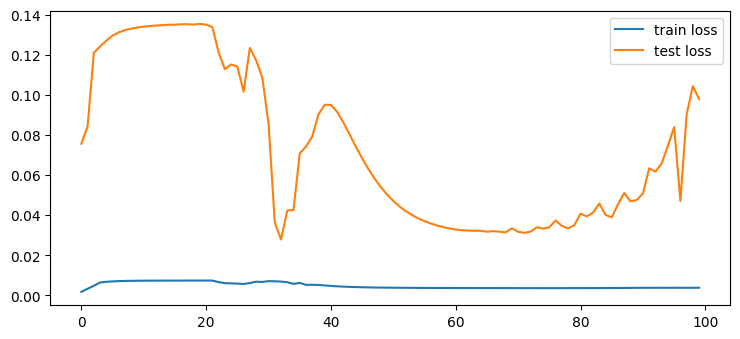

In [357]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        optimizer.zero_grad()

        loss = loss_function(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

train_losses = []
test_losses = []


for ix_epoch in range(epochs_count):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    train_losses.append(train_loss)
    test_loss = test_model(test_loader, model, loss_function)
    test_losses.append(test_loss)

    print()

fig, ax = plt.subplots(1,1)
    
ax.plot(train_losses, label='train loss')
ax.plot(test_losses, label='test loss')
ax.legend()

In [358]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output


train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

predict_col = "forecast"

df_train[predict_col] = predict(train_eval_loader, model).numpy()
df_test[predict_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, predict_col]]

df_out = pd.DataFrame(sc.inverse_transform(df_out), columns=df_out.columns)


print(df_out)

        close    forecast
0      121.11  131.247678
1      121.11  131.247678
2      121.11  131.247678
3      121.11  130.681021
4      121.11  130.686786
...       ...         ...
30609  237.06  175.458482
30610  237.06  172.855178
30611  237.06  173.445629
30612  237.06  175.458482
30613  237.06  172.855178

[30614 rows x 2 columns]


/var/folders/4z/tbymbl2s59dcpbxbxz0j0ys40000gn/T/ipykernel_99215/2673632109.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[predict_col] = predict(train_eval_loader, model).numpy()
/var/folders/4z/tbymbl2s59dcpbxbxz0j0ys40000gn/T/ipykernel_99215/2673632109.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[predict_col] = predict(test_loader, model).numpy()


In [359]:
def running_mean(x, N,mode='valid'):
    return np.convolve(x, np.ones((N,))/N, mode=mode)

def model_results(moving_average=None):
    y_test = df_test['close']
    y_test_pred = df_test[predict_col]
    print('Test MSE', mean_squared_error(y_test, y_test_pred))
    print('Test MAPE', mean_absolute_percentage_error(y_test, y_test_pred))
    y_pred = df_out[predict_col]
    y = df_out['close']
    if moving_average:
        y_pred = running_mean(y_pred, moving_average)
        
        y_test_pred_smooth = running_mean(y_test_pred, moving_average, mode='same')
        print('Smoothed Test MSE', mean_squared_error(y_test, y_test_pred_smooth))
        print('Smoothed Test MAPE', mean_absolute_percentage_error(y_test, y_test_pred_smooth))
    fig, ax = plt.subplots(1,1)
    train_size = len(df_train)
    y_pred = pd.Series(y_pred)
    ax.plot(y, label='true')
    ax.plot(y_pred, label='pred')
    ax.set_ylim((y.min()-10, y.max()+10))
    plt.axvline(x=train_size, c='r', linestyle='--')
    ax.legend()

Test MSE 0.09673077408908154
Test MAPE 0.349740083265092
Smoothed Test MSE 0.05826660214333657
Smoothed Test MAPE 0.2963869166211496


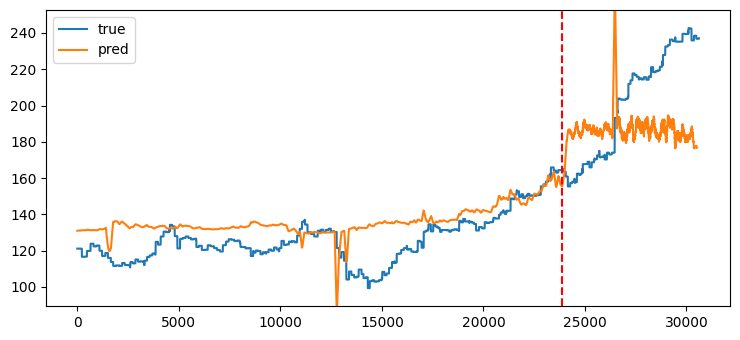

In [360]:
model_results(moving_average=100)

Test MSE 2.756208348241307
Test MAPE 1.4173885617097328


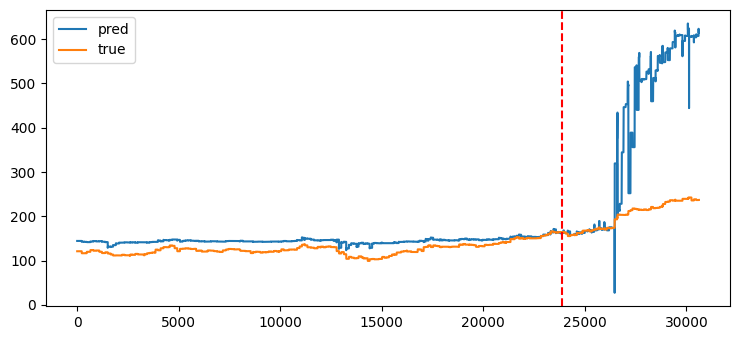

In [308]:
model_results(moving_average=None)

Test MSE 0.09756707166815759
Test MAPE 0.2783061130683868


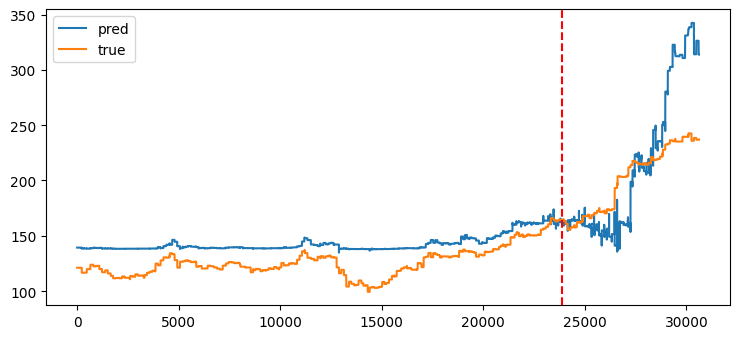

In [318]:
model_results(moving_average=None)

Test MSE 0.12418443184616851
Test MAPE 0.32524781154785193


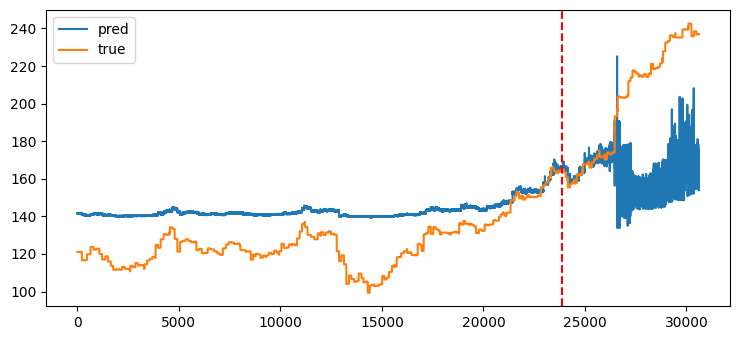

In [329]:
model_results(moving_average=None)

Test MSE 0.007547988662526805
Test MAPE 0.07306125655346457
Smoothed Test MSE 0.003664646184161653
Smoothed Test MAPE 0.06622785555877614


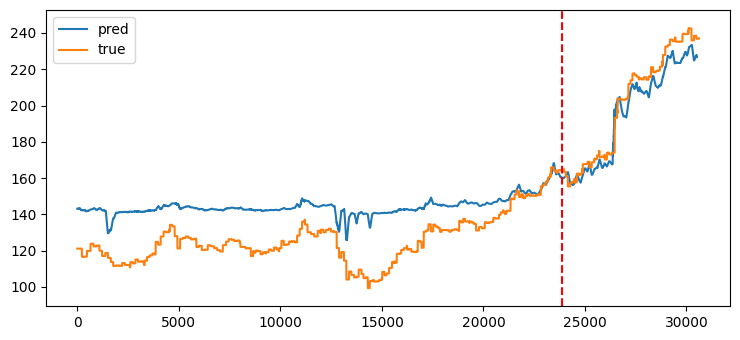

In [346]:
model_results(moving_average=100)